# Cleaning, Exploratory Data Analysis, and Natural Language Processing

In this portion of my project, I will walk through my steps for cleaning my data and processing it into features useful for quantitative modeling. 

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import wordnet

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
# Reading in CasualConversations dataframe 
casual = pd.read_csv('./Data/casual_convo.csv')

/Users/johnnybex/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,9,72,73) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Reading in PoliticalDiscussions dataframe
political = pd.read_csv('./Data/politics.csv')

/Users/johnnybex/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,4,6,8,9,10,11,12,16,18,19,20,21,22,24,26,27,28,30,31,33,34,38,40,46,47,52,53,57,60,65,68,70,71,74,95,96,97,98) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# CasualConversations data and features 
casual.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_template_id,link_flair_text,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,link_flair_css_class,removed_by_category,poll_data,author_flair_background_color,author_flair_text_color,banned_by,edited,author_flair_template_id,post_hint,preview,author_cakeday,distinguished,collections,discussion_type,suggested_sort,gilded
0,[],False,V-Jessica-V,NaN,[],NaN,text,t2_9v0jl1t6,False,False,[],False,False,1611880538,self.CasualConversation,https://www.reddit.com/r/CasualConversation/co...,{},l7e0yt,True,False,False,False,True,True,False,#638be4,"[{'a': ':chat:', 'e': 'emoji', 'u': 'https://e...",58904be0-3089-11e9-b6c6-0e12b0807136,:chat: Just Chatting,light,richtext,False,False,False,0,0,False,all_ads,/r/CasualConversation/comments/l7e0yt/f_21_loo...,False,6,1611880549,1,(Name): Jessica\n(Age): 21\n(Height): 5’10 (So...,True,False,False,CasualConversation,t5_323oy,1440677,public,self,"F, 21. Looking for people to chat to :D",0,[],1.0,https://www.reddit.com/r/CasualConversation/co...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,shaggy1452,NaN,[],NaN,text,t2_178m2o,False,False,[],False,False,1611880297,self.CasualConversation,https://www.reddit.com/r/CasualConversation/co...,{},l7dxgq,True,False,False,False,True,True,False,#638be4,"[{'a': ':chat:', 'e': 'emoji', 'u': 'https://e...",58904be0-3089-11e9-b6c6-0e12b0807136,:chat: Just Chatting,light,richtext,False,False,True,0,0,False,all_ads,/r/CasualConversation/comments/l7dxgq/did_my_f...,False,6,1611880308,1,I haven’t done contact spirts (or any sports b...,True,False,False,CasualConversation,t5_323oy,1440674,public,self,Did my first Brazilian Jiujitsu class today,0,[],1.0,https://www.reddit.com/r/CasualConversation/co...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,old_lady_young_body,NaN,[],NaN,text,t2_7bvilq6l,False,False,[],False,False,1611879395,self.CasualConversation,https://www.reddit.com/r/CasualConversation/co...,{},l7dku0,True,False,False,False,True,True,False,NaN,[],NaN,NaN,dark,text,False,False,True,0,0,False,all_ads,/r/CasualConversation/comments/l7dku0/cleaning...,False,6,1611879405,1,Guyssssssssssssss maybe I'm late to the game o...,True,False,False,CasualConversation,t5_323oy,1440656,public,self,Cleaning my converse,0,[],1.0,https://www.reddit.com/r/CasualConversation/co...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,randomusername_741,NaN,[],NaN,text,t2_8ppfhsf5,False,False,[],False,False,1611879042,self.CasualConversation,https://www.reddit.com/r/CasualConversation/co...,{},l7dfv6,True,False,False,False,True,True,False,#638be4,"[{'a': ':chat:', 'e': 'emoji', 'u': 'https://e...",58904be0-3089-11e9-b6c6-0e12b0807136,:chat: Just Chatting,light,richtext,False,False,False,5,0,False,all_ads,/r/CasualConversation/comments/l7dfv6/do_you_t...,False,6,1611879052,1,\n\n[View Poll](https://www.reddit.com/poll/l7...,True,False,False,CasualConversation,t5_323oy,1440646,public,self,Do you think brutal honesty is good?,0,[],1.0,https://www.reddit.com/r/CasualConversation/co...,all_ads,6,NaN,NaN,"{'is_prediction': False, 'options': [{'id': '5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Internal_Use8954,NaN,[],NaN,text,t2_2smn61ln,False,F

Of all the features in CasualConversation queries, I am most interested in :
* subreddit
* author
* selftext (text in each submission)
* title (title of eachpost)
* id (to determine if all posts are unique)

In [6]:
# List of columns I am interested in 
columns = ['subreddit', 'author', 'selftext', 'title', 'id']

In [7]:
# Filtering CasualConversation dataframe for the features I am interested in 
casual = casual[columns]

In [8]:
# Filtering PoliticalDiscussion dataframe for the features I am interested in
political = political[columns]

In [9]:
# Concatenaating the filtered casual and political DataFrames
df = pd.concat([casual, political], ignore_index=True)

In [10]:
# Engineering binary feature for distinguishing between subreddits
df['binary_sub'] = df['subreddit'].map({'CasualConversation':0, 'PoliticalDiscussion':1})

In [11]:
# Engineering a feature that is composed of both title and post text
df['totaltext'] = df['selftext'] + ' ' + df['title']

### Class Balance 

When evaluating classification models, it is important to keep in mind class imbalance. I want to ensure that I have balanced classes for my models, meaning I need to evaluate how many observations are in each subreddit. 

In [12]:
# Evaluating class balance
df['binary_sub'].value_counts(normalize=True)

0    0.501446
1    0.498554
Name: binary_sub, dtype: float64

These equal values confirm that my classes are balanced for future modeling. Therefore, we do not have to account for unbalanced classes in future modeling

### Sentiment Analysis 

I want to investigate whether the sentiment expressed in the posts in each subreddit helps differentiate between the  political and casual conversations. 

In [13]:
# Instantiating VADER sentiment analyzer 
analyzer = SentimentIntensityAnalyzer()

# Creating columns for each vader sentiment measurement
for count, text in enumerate(df['totaltext']):
    vs = analyzer.polarity_scores(text)
    df.loc[count, 'vader_negative'] = vs['neg']
    df.loc[count, 'vader_positive'] = vs['pos']
    df.loc[count, 'vader_neutral'] = vs['neu']
    df.loc[count, 'vader_compound'] = vs['compound']

In [14]:
df.head()

,subreddit,author,selftext,title,id,binary_sub,totaltext,vader_negative,vader_positive,vader_neutral,vader_compound
0,CasualConversation,V-Jessica-V,(Name): Jessica\n(Age): 21\n(Height): 5’10 (So...,"F, 21. Looking for people to chat to :D",l7e0yt,0,(Name): Jessica\n(Age): 21\n(Height): 5’10 (So...,0.153,0.241,0.606,0.9334
1,CasualConversation,shaggy1452,I haven’t done contact spirts (or any sports b...,Did my first Brazilian Jiujitsu class today,l7dxgq,0,I haven’t done contact spirts (or any sports b...,0.063,0.146,0.791,0.9431
2,CasualConversation,old_lady_young_body,Guyssssssssssssss maybe I'm late to the game o...,Cleaning my converse,l7dku0,0,Guyssssssssssssss maybe I'm late to the game o...,0.057,0.159,0.784,0.8417
3,CasualConversation,randomusername_741,\n\n[View Poll](https://www.reddit.com/poll/l7...,Do you think brutal honesty is good?,l7dfv6,0,\n\n[View Poll](https://www.reddit.com/poll/l7...,0.253,0.377,0.370,0.2500
4,CasualConversation,Internal_Use8954,Title says it. It was Ben &amp; Jerry's Pistac...,I just tried pistachio ice cream for the first...,l7d0tf,0,Title says it. It was Ben &amp; Jerry's Pistac...,0.064,0.115,0.820,0.7401


In [15]:
# Grouping by subreddit
binary_gb = df.groupby('subreddit')

# Evaluating mean sentiment score by subreddit
sentiment_by_sub = binary_gb[['vader_negative', 'vader_positive', 'vader_neutral'
                             ,'vader_compound']].mean().T
sentiment_by_sub

subreddit,CasualConversation,PoliticalDiscussion
vader_negative,0.071895,0.060412
vader_positive,0.144083,0.107310
vader_neutral,0.784020,0.832281
vader_compound,0.448605,0.347839


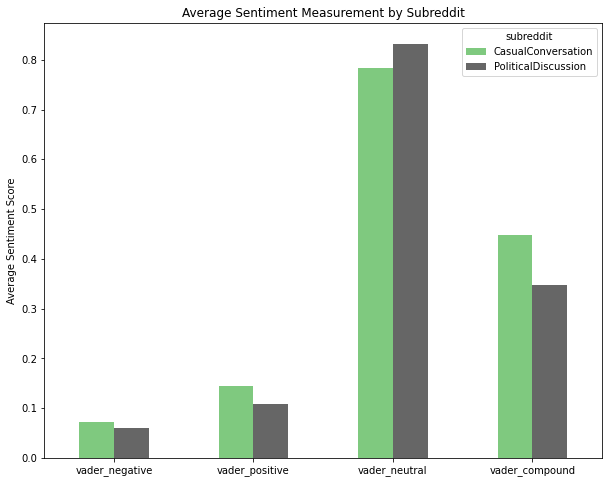

In [16]:
# Plotting the average vader scores by subreddit
sentiment_by_sub.plot(kind='bar', figsize=(10,8), colormap='Accent',
                     title='Average Sentiment Measurement by Subreddit',
                    ylabel='Average Sentiment Score', rot=0
                     );


#### Analysis:
The compound vader score differs for each subreddit, however the difference between the two is only 0.1. Therefore, my hypothesis is that the sentiment analysis will not be a significant feature for differentiating between the two subreddits. However, I will investigate this in my first model (logistic regression) to determine if it should be a feature kept for subsequent models (random forest, svm). 

### Cleaning Title and Post Text

There are sentences in each subreddit that has special characters, punctuation, and occasionally foreign language. Therefore it is necessary to clean the text in each post's title and text.

In [17]:
def regex_remover(column):
    '''
    Removes problematic characters for NLTK preprocessing using regular 
    expressions.
    
    ---
    returns
    Type:Dataframe 
        Cleaned feature DataFrame
    ---
    parameters
    Series 
        DataFrame feature that needs to be cleaned 
    '''
    
    # https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
    # removing urls
    df[column] = df[column].map(lambda x: re.sub(r'http[s]?://\S+', '', x)) 

    # https://stackoverflow.com/questions/5075247/regular-expression-to-remove-line-breaks
    # Removing line breaks
    df[column] = df[column].map(lambda x: re.sub(r"(?<=[a-z])\r\n", ' ', x)) 

    #https://stackoverflow.com/questions/14596884/remove-text-between-and
    #removing text in brackets
    df[column] = df[column].map(lambda x: re.sub(r"[\(\[].*?[\)\]]", ' ', x)) 
    
    
    #df[column] = df[column].map(lambda x: re.sub(r'\d+', ' ', x)) # Deleting numbers
    
    # https://stackoverflow.com/questions/12985456/replace-all-non-alphanumeric-characters-in-a-string
    # Only keeping letters
    df[column] = df[column].map(lambda x: re.sub(r'[^a-zA-Z]', ' ', x)) 

    #https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
    # Removing all punctuation
    df[column] = df[column].map(lambda x: re.sub(r'[^\w\s]', ' ', x)) 

    return df

In [18]:
# Cleaning the post text 
df = regex_remover('selftext')

# Cleaning the title text
df = regex_remover('title')

In [19]:
# Engineering feature that is combined clean post and title text
df['totaltext'] = df['selftext'] + ' ' + df['title']

In [20]:
# Updated DataFrame
df.head()

,subreddit,author,selftext,title,id,binary_sub,totaltext,vader_negative,vader_positive,vader_neutral,vader_compound
0,CasualConversation,V-Jessica-V,Jessica D drinking and ...,F Looking for people to chat to D,l7e0yt,0,Jessica D drinking and ...,0.153,0.241,0.606,0.9334
1,CasualConversation,shaggy1452,I haven t done contact spirts since i was a ...,Did my first Brazilian Jiujitsu class today,l7dxgq,0,I haven t done contact spirts since i was a ...,0.063,0.146,0.791,0.9431
2,CasualConversation,old_lady_young_body,Guyssssssssssssss maybe I m late to the game o...,Cleaning my converse,l7dku0,0,Guyssssssssssssss maybe I m late to the game o...,0.057,0.159,0.784,0.8417
3,CasualConversation,randomusername_741,,Do you think brutal honesty is good,l7dfv6,0,Do you think brutal honesty is good,0.253,0.377,0.370,0.2500
4,CasualConversation,Internal_Use8954,Title says it It was Ben amp Jerry s Pistac...,I just tried pistachio ice cream for the first...,l7d0tf,0,Title says it It was Ben amp Jerry s Pistac...,0.064,0.115,0.820,0.7401


In [21]:
# Ensuring that each post is unique (no duplicates)

len(df['id'].unique())

# Each post is unique 

20058

### Word Count Distribution

Want to visualize if one subreddit is more likely to have longer posts than the other. 

Mean amount of words in CasualConversation post: 142.47226088685625
Mean amount of words in PoliticalDiscussion post: 123.6786


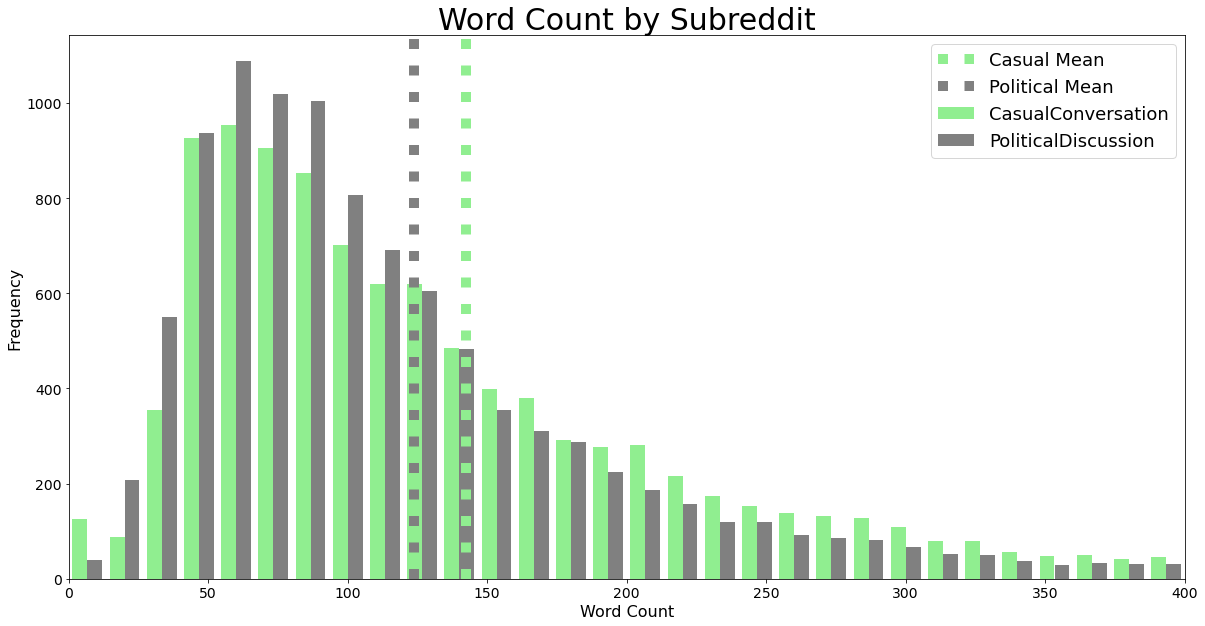

In [22]:
# Creating mask for each subreddit
casual_mask = df[df['binary_sub'] == 0]
political_mask = df[df['binary_sub'] == 1]

# Calculating the mean number of words in each subreddit
mean_casual_words = casual_mask['totaltext'].str.split().str.len().mean()
mean_political_words = political_mask['totaltext'].str.split().str.len().mean()
print('Mean amount of words in CasualConversation post:', mean_casual_words)
print('Mean amount of words in PoliticalDiscussion post:', mean_political_words)

plt.figure(figsize=(20,10))

# Creating histogram of the number of words in each post per subreddit
plt.hist([casual_mask['totaltext'].apply(lambda x: len(x.split())), 
          political_mask['totaltext'].apply(lambda x: len(x.split()))],
         bins=30, range = (0, 400), color=['lightgreen','grey'])

plt.xlim((0,400))

# Plotting mean word count per post per subreddit
plt.axvline(mean_casual_words, color='lightgreen',linewidth=10, linestyle=':')
plt.axvline(mean_political_words, color='grey', linewidth=10, linestyle=':')

plt.legend(['Casual Mean', 'Political Mean', 'CasualConversation', 'PoliticalDiscussion'], fontsize = 18);

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Word Count by Subreddit', fontsize = 30)
plt.xlabel('Word Count', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16);


### Analysis 

The number of words per post in each subreddit is skewed to the right for both subreddits. Posts that are shorter than 150 words are more likely to be political posts, posts greater than 150 words are more likely to be casual conversations. However, word count is not a great feature for classification because of how similar the word count per post in each subreddit for every word count bin.\
\
I will be using TF-IDF vectorization in my modeling pipeline, which will account for the frequency of each word in the entire corpus of text from both subreddits. Therefore, it is not integral to evaluate how much text is in each subreddit, it will automatically be scaled for me. 

## Parts of Speech Proportion in each post 

I want to evaluate whether the subreddit posts use different part-of-speech proportions. I am curious if there is a lot of syntactic variety between the posts of the two subreddits. 

In [23]:
# https://stackoverflow.com/questions/10674832/count-verbs-nouns-and-other-parts-of-speech-with-pythons-nltk

def pos_counter(text):
    '''
    Tags each word in string and returns count for each part-of-speech
    
    ---
    Returns
    type: Counter
        Counter dictionary with count of each pos-tag
        
    ---
    Parameters
    type: String
        String of words to be pos-tagged
    '''
    # Tokenizing the string
    tok = WordPunctTokenizer()
    
    # POS-tagging
    tagger = pos_tag(tok.tokenize(text))
    
    #Counting occurences of tag in each string 
    counts = Counter(tag for word, tag in tagger)
    return counts              

In [24]:
# Feature Engineering column with total count of each part of speech 
df['pos_counts'] = df['totaltext'].apply(lambda x: pos_counter(x))

In [25]:
# Creating list of all types of parts-of-speech tag
pos_list = list(df.loc[0,'pos_counts'].keys())

In [26]:
# Engineering columns with proportion of each part-of-speech tag in text
for pos in pos_list:
    total = df['pos_counts'].map(lambda x: sum(x.values()))
    df[pos] = df['pos_counts'].map(lambda x: x.get(pos))
    # Filling pos column with zero if null
    df[pos] = df[pos].fillna(0)
    # Getting proportion of each part of speech tag per text
    df[pos] = df[pos]/total
    df[pos] = df[pos].fillna(0)

In [27]:
df.head()

,subreddit,author,selftext,title,id,binary_sub,totaltext,vader_negative,vader_positive,vader_neutral,vader_compound,pos_counts,NNP,NN,CC,JJ,NNS,VBP,PRP,DT,RB,RBR,IN,PRP$,VB,VBG,VBN,TO
0,CasualConversation,V-Jessica-V,Jessica D drinking and ...,F Looking for people to chat to D,l7e0yt,0,Jessica D drinking and ...,0.153,0.241,0.606,0.9334,"{'NNP': 6, 'NN': 11, 'CC': 3, 'JJ': 11, 'NNS':...",0.072289,0.132530,0.036145,0.132530,0.096386,0.096386,0.108434,0.036145,0.060241,0.012048,0.096386,0.012048,0.048193,0.024096,0.012048,0.024096
1,CasualConversation,shaggy1452,I haven t done contact spirts since i was a ...,Did my first Brazilian Jiujitsu class today,l7dxgq,0,I haven t done contact spirts since i was a ...,0.063,0.146,0.791,0.9431,"{'PRP': 15, 'VBP': 9, 'JJ': 14, 'VBN': 2, 'NN'...",0.013072,0.156863,0.019608,0.091503,0.026144,0.058824,0.098039,0.078431,0.052288,0.000000,0.111111,0.026144,0.058824,0.039216,0.013072,0.045752
2,CasualConversation,old_lady_young_body,Guyssssssssssssss maybe I m late to the game o...,Cleaning my converse,l7dku0,0,Guyssssssssssssss maybe I m late to the game o...,0.057,0.159,0.784,0.8417,"{'NNP': 2, 'RB': 6, 'PRP': 13, 'VBP': 7, 'JJ':...",0.027027,0.094595,0.054054,0.094595,0.040541,0.094595,0.175676,0.054054,0.081081,0.000000,0.067568,0.027027,0.027027,0.013514,0.013514,0.027027
3,CasualConversation,randomusername_741,,Do you think brutal honesty is good,l7dfv6,0,Do you think brutal honesty is good,0.253,0.377,0.370,0.2500,"{'VBP': 1, 'PRP': 1, 'VB': 1, 'JJ': 2, 'NN': 1...",0.000000,0.142857,0.000000,0.285714,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000
4,CasualConversation,Internal_Use8954,Title says it It was Ben amp Jerry s Pistac...,I just tried pistachio ice cream for the first...,l7d0tf,0,Title says it It was Ben amp Jerry s Pistac...,0.064,0.115,0.820,0.7401,"{'NNP': 9, 'VBZ': 3, 'PRP': 20, 'VBD': 10, 'NN...",0.060403,0.154362,0.040268,0.073826,0.033557,0.040268,0.134228,0.060403,0.080537,0.000000,0.087248,0.020134,0.053691,0.013423,0.000000,0.020134


In [28]:
subreddit_gb = df.loc[:, pos_list + ['subreddit']].groupby('subreddit')
subreddit_pos_gb = subreddit_gb.mean().T

Text(0.5, 1.0, 'Average Proportion of Each Part of Speech by Subreddit')

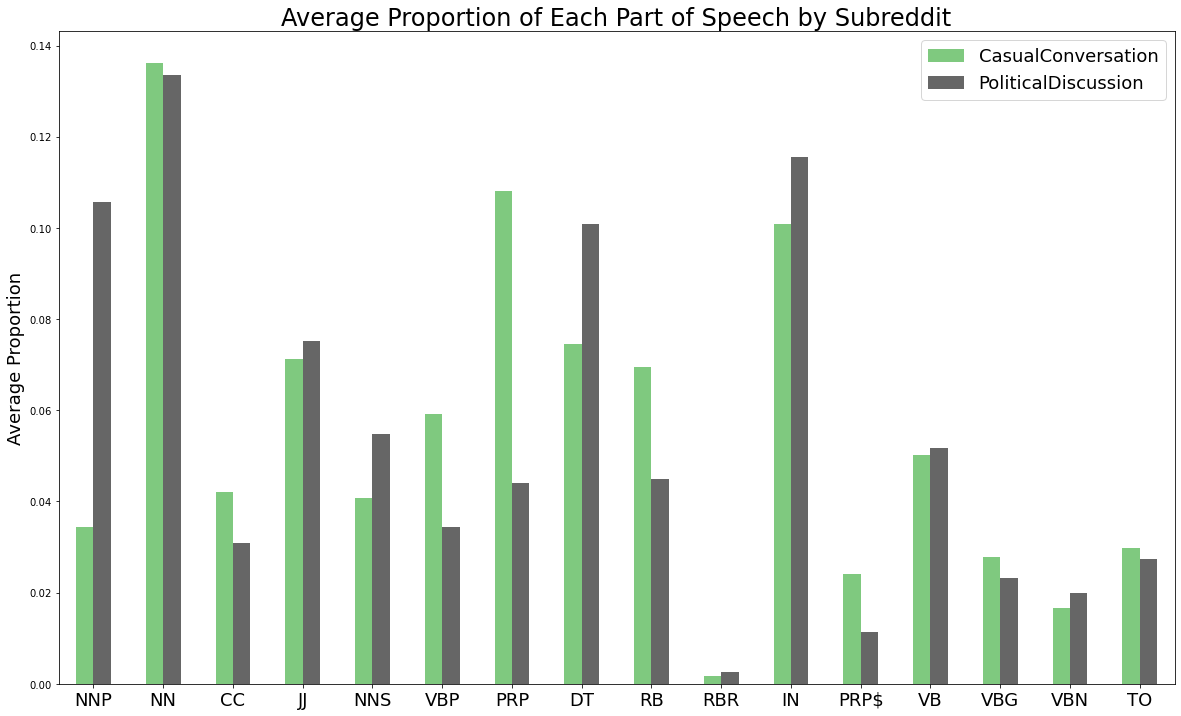

In [29]:
subreddit_pos_gb.plot(kind='bar', figsize=(20,12), colormap='Accent');
plt.legend(fontsize=(18))
plt.ylabel('Average Proportion', fontsize=(18))
plt.xticks(fontsize=(18), rotation=0)
plt.title('Average Proportion of Each Part of Speech by Subreddit', fontsize=(24))

### Analysis 

Some parts-of-speech are used much more frequently in each subreddit. For example, proper nouns are used much more frequently in the political subreddit, probably because the subreddit discussed the actions of individual politicians. Pronouns are used much more frequently in the casual conversation subreddit because individuals are not discussed.  

* CC: conjunction, coordinating
    * Ex: &, 'n, and, both, but, either, et, for, less, minus, neither, nor, or, plus, so
therefore times v. versus vs. whether yet
* DT: determiner
    * Ex: all, an, another, any, both, each, either, every, half, many, much,
neither no some such that the them these this those
* IN: preposition or conjunction, subordinating
* JJ: adjective or numeral, ordinal
* MD: modal auxiliary
    * Ex: can, cannot, could, couldn't, dare, may, might, must, need, ought, shall, should, shouldn't, will, would
* NN: noun, common, singular or mass
* NNP: noun, proper, singular
* NNS: noun, common, plural
* PRP: pronoun, personal
* PRP$: pronoun, possessive
* RB: adverb
* RBR: adverb, comparative
* TO: "to" as preposition or infinitive marker
* VB: verb, base form
* VBD: verb, past tense
* VBG: verb, present participle or gerund
* VBN: verb, past participle
* VBP: verb, present tense, not 3rd person singular

### NLTK Pre-Processing: Lemmatization

Lemmatization gives us the dictionary meaning word while converting the word to root form. By lemmatizing, we are able to get more accurate results because we are reducing the variability in word structure while retaining the meaning of the word. Therefore we are extracting same information from less variable data, optimizing performance of the model. 

To accurately lemmatize in python, we can ascribe parts-of-speech tags to each word so that each the lemmatization function understands the context of the word to reduce it to its most base form.

In [30]:
# https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk
# https://stackoverflow.com/questions/51267166/lemmatization-pandas-python

def nltk_tag_to_wordnet_tag(nltk_tag):
    '''
    Tagging each word in a string with its corresponding wordnet 
    part-of-speech. Necessary for wordnet lemmatization. 
    
    ---
    Returns
    Type: Wordnet part-of-speech-tag or None
    
    ---
    Parameters
    Type: String
    '''
    
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [31]:
# https://stackoverflow.com/questions/51267166/lemmatization-pandas-python

def lemmatize_text(sentence):
    '''
    Lemmatizes each word in a sentence based on parts-of-speech tag.
    
    ---
    Returns
    type: String
        String of lemmatized words 
        
    ---
    Parameters
    type: String
        String whose words need to be lemmatized. 
    '''
    
    #tokenize the sentence and find the POS tag for each token
    lemmatizer = WordNetLemmatizer()
    tok = WordPunctTokenizer()
    tagger = pos_tag(tok.tokenize(sentence))
    
    # Getting tag for each word in tokenized text
    pos_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), tagger)
    
    # Instantietating empty lemmas list
    lemmas = []
    
    # Unpacking word and pos-tag for each word in text
    for word, tag in pos_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmas.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmas.append(lemmatizer.lemmatize(word, tag))
            
    # Returning string of lemmatized text 
    return " ".join(lemmas)

In [32]:
# Lemmatizing the post text
df['lemma_text'] = df['selftext'].apply(lambda x: lemmatize_text(x))

In [33]:
# Lemmatizing the title of each post
df['lemma_title'] = df['title'].apply(lambda x: lemmatize_text(x))

In [34]:
# Engineering a feature that is the total lemmatized text 
df['lemma_totaltext'] = df['lemma_title'] + ' ' + df['lemma_text']

In [35]:
# Ensuring that no nulls in DataFrame 
df.isnull().sum()

subreddit          0
author             0
selftext           0
title              0
id                 0
binary_sub         0
totaltext          0
vader_negative     0
vader_positive     0
vader_neutral      0
vader_compound     0
pos_counts         0
NNP                0
NN                 0
CC                 0
JJ                 0
NNS                0
VBP                0
PRP                0
DT                 0
RB                 0
RBR                0
IN                 0
PRP$               0
VB                 0
VBG                0
VBN                0
TO                 0
lemma_text         0
lemma_title        0
lemma_totaltext    0
dtype: int64

In [36]:
# Updated DataFrame
df.head()

,subreddit,author,selftext,title,id,binary_sub,totaltext,vader_negative,vader_positive,vader_neutral,vader_compound,pos_counts,NNP,NN,CC,JJ,NNS,VBP,PRP,DT,RB,RBR,IN,PRP$,VB,VBG,VBN,TO,lemma_text,lemma_title,lemma_totaltext
0,CasualConversation,V-Jessica-V,Jessica D drinking and ...,F Looking for people to chat to D,l7e0yt,0,Jessica D drinking and ...,0.153,0.241,0.606,0.9334,"{'NNP': 6, 'NN': 11, 'CC': 3, 'JJ': 11, 'NNS':...",0.072289,0.132530,0.036145,0.132530,0.096386,0.096386,0.108434,0.036145,0.060241,0.012048,0.096386,0.012048,0.048193,0.024096,0.012048,0.024096,Jessica D drinking and chain smoking DC comic ...,F Looking for people to chat to D,F Looking for people to chat to D Jessica D dr...
1,CasualConversation,shaggy1452,I haven t done contact spirts since i was a ...,Did my first Brazilian Jiujitsu class today,l7dxgq,0,I haven t done contact spirts since i was a ...,0.063,0.146,0.791,0.9431,"{'PRP': 15, 'VBP': 9, 'JJ': 14, 'VBN': 2, 'NN'...",0.013072,0.156863,0.019608,0.091503,0.026144,0.058824,0.098039,0.078431,0.052288,0.000000,0.111111,0.026144,0.058824,0.039216,0.013072,0.045752,I haven t do contact spirt since i be a high s...,Did my first Brazilian Jiujitsu class today,Did my first Brazilian Jiujitsu class today I ...
2,CasualConversation,old_lady_young_body,Guyssssssssssssss maybe I m late to the game o...,Cleaning my converse,l7dku0,0,Guyssssssssssssss maybe I m late to the game o...,0.057,0.159,0.784,0.8417,"{'NNP': 2, 'RB': 6, 'PRP': 13, 'VBP': 7, 'JJ':...",0.027027,0.094595,0.054054,0.094595,0.040541,0.094595,0.175676,0.054054,0.081081,0.000000,0.067568,0.027027,0.027027,0.013514,0.013514,0.027027,Guyssssssssssssss maybe I m late to the game o...,Cleaning my converse,Cleaning my converse Guyssssssssssssss maybe I...
3,CasualConversation,randomusername_741,,Do you think brutal honesty is good,l7dfv6,0,Do you think brutal honesty is good,0.253,0.377,0.370,0.2500,"{'VBP': 1, 'PRP': 1, 'VB': 1, 'JJ': 2, 'NN': 1...",0.000000,0.142857,0.000000,0.285714,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,,Do you think brutal honesty be good,Do you think brutal honesty be good
4,CasualConversation,Internal_Use8954,Title says it It was Ben amp Jerry s Pistac...,I just tried pistachio ice cream for the first...,l7d0tf,0,Title says it It was Ben amp Jerry s Pistac...,0.064,0.115,0.820,0.7401,"{'NNP': 9, 'VBZ': 3, 'PRP': 20, 'VBD': 10, 'NN...",0.060403,0.154362,0.040268,0.073826,0.033557,0.040268,0.134228,0.060403,0.080537,0.000000,0.087248,0.020134,0.053691,0.013423,0.000000,0.020134,Title say it It be Ben amp Jerry s Pistachio I...,I just try pistachio ice cream for the first t...,I just try pistachio ice cream for the first t...


### Creating cleaned dataframe with interesting features 

In [37]:
# Features I am interested in 
df = df[['binary_sub', 'NN', 'NNP', 'VBG', 'PRP', 'VBP', 'TO', 'VB','IN', 'CC',
        'JJ', 'NNS', 'DT', 'RB', 'RBR', 'PRP$', 'VBN', 'vader_negative', 
         'vader_positive', 'vader_neutral','vader_compound', 'lemma_totaltext']]

In [38]:
df.head()

,binary_sub,NN,NNP,VBG,PRP,VBP,TO,VB,IN,CC,JJ,NNS,DT,RB,RBR,PRP$,VBN,vader_negative,vader_positive,vader_neutral,vader_compound,lemma_totaltext
0,0,0.132530,0.072289,0.024096,0.108434,0.096386,0.024096,0.048193,0.096386,0.036145,0.132530,0.096386,0.036145,0.060241,0.012048,0.012048,0.012048,0.153,0.241,0.606,0.9334,F Looking for people to chat to D Jessica D dr...
1,0,0.156863,0.013072,0.039216,0.098039,0.058824,0.045752,0.058824,0.111111,0.019608,0.091503,0.026144,0.078431,0.052288,0.000000,0.026144,0.013072,0.063,0.146,0.791,0.9431,Did my first Brazilian Jiujitsu class today I ...
2,0,0.094595,0.027027,0.013514,0.175676,0.094595,0.027027,0.027027,0.067568,0.054054,0.094595,0.040541,0.054054,0.081081,0.000000,0.027027,0.013514,0.057,0.159,0.784,0.8417,Cleaning my converse Guyssssssssssssss maybe I...
3,0,0.142857,0.000000,0.000000,0.142857,0.142857,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.253,0.377,0.370,0.2500,Do you think brutal honesty be good
4,0,0.154362,0.060403,0.013423,0.134228,0.040268,0.020134,0.053691,0.087248,0.040268,0.073826,0.033557,0.060403,0.080537,0.000000,0.020134,0.000000,0.064,0.115,0.820,0.7401,I just try pistachio ice cream for the first t...


In [39]:
# Shuffling all observations so that train-test-spit is not biased
df = df.sample(n=len(df), replace = False).reset_index(drop=True)

In [40]:
df.to_csv('./Data/casual_political.csv', index=False)

### Analyze if Data Leakage is Occurring by including word 'Politic' in model

Want to ensure that model is not classifying posts based on the presence of politic in posts for political discussion. Will evaluate the impact of data leakage with my Random Forest Model 

In [41]:
for word in ['politics', 'political', 'politic']:
    df['lemma_totaltext'] = df['lemma_totaltext'].str.replace(word, '')

In [42]:
df.to_csv('./Data/casual_political_2.csv', index=False)

I will be able to answer my problem statement given the data I have collected, I have more than enough text to begin training a classification model. 

# Please Continue to Notebook 3A